# This notebook is for the creation of images which are then turned into videos

#### First import the required modules

Also grab useful globals and initialise matplotlib with nicer parameters

In [1]:
# Show plots in the browser
%matplotlib inline
#%matplotlib notebook

import matplotlib as mpl
import matplotlib.colors as col
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
#from matplotlib.colors import Normalize
import numpy as np
from datetime import datetime,timedelta

# Display an image from file:
from IPython.display import Image
#Image(filename='test.png') 

from utilities import plotting, utils, fio




In [2]:
# Load the first sirivan output time step, this is used to show example plots
## Read sir ivan data
#sirivan = fio.read_sirivan([fio._files_sirivan_[0]])

## Read waroona data (takes 1-2 minutes)
dtime=datetime(2016,1,5,15)
waroona_outputs = fio.read_waroona(dtime)
slv, ro1, th1, th2 = waroona_outputs



INFO: Reading  data/waroona/umnsaa_2016010515_slv.nc  ... 
INFO: finished reading  data/waroona/umnsaa_2016010515_slv.nc
INFO: Reading  data/waroona/umnsaa_2016010515_mdl_ro1.nc  ... 
INFO: finished reading  data/waroona/umnsaa_2016010515_mdl_ro1.nc
INFO: Reading  data/waroona/umnsaa_2016010515_mdl_th1.nc  ... 
INFO: finished reading  data/waroona/umnsaa_2016010515_mdl_th1.nc
INFO: Reading  data/waroona/umnsaa_2016010515_mdl_th2.nc  ... 
INFO: finished reading  data/waroona/umnsaa_2016010515_mdl_th2.nc


In [3]:

for i in range(4):
    print("==== %s ===="%(['slv','ro1','th1','th2'][i]))
    for k,v in waroona_outputs[i].items():
        print(k, np.shape(v))

topog,latt,lont = fio.read_topog('data/waroona/topog.nc')
## (just want winds, w, topography, and zth)
waroona={}
waroona['wind_speed'] = ro1['wind_speed']
waroona['x_wind_destaggered'] = ro1['x_wind_destaggered']
waroona['y_wind_destaggered'] = ro1['y_wind_destaggered']
waroona['topog'] = topog
waroona['zth'] = th1['zth']
waroona['latitude'] = slv['latitude']
waroona['longitude'] = slv['longitude']
waroona['upward_air_velocity'] = th1['upward_air_velocity']


==== slv ====
specific_humidity (6, 576, 576)
surface_air_pressure (6, 576, 576)
air_pressure_at_sea_level (6, 576, 576)
surface_altitude (576, 576)
surface_temperature (6, 576, 576)
time (6,)
latitude (576,)
longitude (576,)
==== ro1 ====
air_pressure (6, 140, 576, 576)
x_wind (6, 140, 576, 576)
y_wind (6, 140, 577, 576)
height_above_reference_ellipsoid (140, 576, 576)
time (6,)
level_height (140,)
latitude (576,)
longitude (576,)
x_wind_destaggered (6, 140, 576, 576)
y_wind_destaggered (6, 140, 576, 576)
wind_speed (6, 140, 576, 576)
==== th1 ====
air_pressure (6, 140, 576, 576)
air_temperature (6, 140, 576, 576)
height_above_reference_ellipsoid (140, 576, 576)
specific_humidity (6, 140, 576, 576)
upward_air_velocity (6, 140, 576, 576)
time (6,)
level_height (140,)
latitude (576,)
longitude (576,)
zth (6, 140, 576, 576)
theta (6, 140, 576, 576)
==== th2 ====
mass_fraction_of_cloud_ice_in_air (6, 140, 576, 576)
mass_fraction_of_cloud_liquid_water_in_air (6, 140, 576, 576)
time (6,)
le

### AFAC Outline of weather at fire site

#### 211 topography, sites of interest, surface wind, and transect line

I can just plot all the sites I have since the map will only show those within the desired extent (boundaries E,W,S,N)

#### 223 vertical motion along transect

#### 224 horizontal wind speed along transect

Transects also show the topography as a black area along the bottom, Eventually we will add colour to this to depict fire heat flux (when I have fire data and I can read it)

In [2]:
def winds_2panel(data,tstep, 
                 extentname='waroona',
                 transect=1, 
                 vectorskip=14,
                 quiverscale=60,
                 dtime=None,
                 ext='.png'
                ):
    '''
    211 Plot showing contour map and wind speed, along with near sites and transect
    223 plot showing vertical motion along transect
    224 plot showing wind speed along transect
    INPUTS:
        topography, vert motion, wind speed, z,lat,lon, 
        extentname = { 'waroona' | 'sirivan' } choice of two fire locations
        transect = int from 1 to 6 for transect choice
        vectorskip reduces quiver density (may need to fiddle)
        quiverscale changes how long the arrows are (also may need to fiddle)
        dtime is datetime of output 
        ext is the plot extension { '.png' | '.eps' }
    '''
    topog=data['topog']
    w=data['upward_air_velocity'][tstep]
    s=data['wind_speed'][tstep]
    u=data['x_wind_destaggered'][tstep]
    v=data['y_wind_destaggered'][tstep]
    z=data['zth'][tstep]
    lat=data['latitude']
    lon=data['longitude']
    
    
    # datetime timestamp for file,title
    if dtime is None:
        dstamp = "20YYMMDDHHMM"
        stitle = dstamp
    else:
        dstamp = dtime.strftime("%Y%m%d%H%M")
        stitle = dtime.strftime("%Y %b %d %H:%M (UTC)")
    # figure name and location
    pname="figures/%s/winds_outline_X%d/fig_%s%s"%(extentname,transect,dstamp,ext)
    
    # set font sizes
    plotting.init_plots()
    
    # get plot extent, and transect
    extent = plotting._extents_[extentname]
    start,end = plotting._transects_["%s%d"%(extentname,transect)]
    
    plt.figure(figsize=[7,10])
    ax1 = plt.subplot(3,1,1)
    
    # top panel is topography
    plotting.map_topography(extent,topog,lat,lon)
    plt.title('Topography, winds')
    
    # start to end x=[lon0,lon1], y=[lat0, lat1]
    plt.plot([start[1],end[1]],[start[0],end[0], ], '--k', 
             linewidth=2, 
             marker='X', markersize=7,markerfacecolor='white')
    
    # add nearby towns
    textcolor='lightgrey'
    if extentname == 'waroona':
        plotting.map_add_locations(['waroona','yarloop'], 
                                   text=['Waroona', 'Yarloop'], 
                                   textcolor=textcolor)
        # add fire ignition
        plotting.map_add_locations(['fire_waroona'],
                                   text = ['Fire ignition'], 
                                   color='r', marker='*', 
                                   textcolor=textcolor)
        # add pyroCB
    else:
        plotting.map_add_locations(['sirivan','uarbry'], 
                                   text=['Sir Ivan','Uarbry'],
                                   dx=[-.02,.05], dy =[-.015,-.03],
                                   textcolor=textcolor)
        # add fire ignition
        plotting.map_add_locations(['fire_sirivan'],
                                   text = ['Fire ignition'], dx=.05,
                                   color='r', marker='*', 
                                   textcolor=textcolor)
        # add pyroCB

    
    # Add vectors for winds
    # just surface, and one every 10 points to reduce density
    skip = (slice(None,None,vectorskip),slice(None,None,vectorskip))
    ## colour the arrows
    # map wind speed to colour map domain [0, 1]
    norm = col.Normalize()
    norm.autoscale(s[skip])
    cmap = plt.get_cmap(plotting._cmaps_['windspeed'])
    plt.quiver(lon[skip[1]],lat[skip[0]],u[0][skip],v[0][skip], scale=quiverscale)
               #color=cmap(norm(s[skip])), 
    
    
    ## Second row is transect plots
    ax2 = plt.subplot(3,1,2)
    plotting.transect_w(w,z, lat, lon,start,end,topog=topog)
    plt.ylabel('height (m)')
    #plt.xlabel('transect')
    
    ax3 = plt.subplot(3,1,3)
    contours=np.arange(0,37,3)
    trs, trx, trz = plotting.transect_s(s,z,lat,lon,start,end,topog=topog,
                                        contours=contours,lines=contours)
    #plt.yticks([])
    xticks,xlabels = plotting.transect_ticks_labels(start,end)
    plt.xticks(xticks[0::2],xlabels[0::2]) # show transect start and end
    
    # Annotate max wind speed
    # only care about lower troposphere
    # 60 levels is about 2800m, 80 levels is about 4700m, 70 levels : 3700m
    upto = 70 
    mloc = np.unravel_index(np.argmax(trs[:upto,:],axis=None),trs[:upto,:].shape)
    note="max = %5.1f m/s\n  (at %4.0f m) "%(trs[:upto,:][mloc], trz[:upto,:][mloc])
    trans = ax3.get_xaxis_transform() # x in data untis, y in axes fraction
    ann = ax3.annotate(note, fontsize=15,
                       xy=(0.33, -0.2 ), xycoords=trans)
    
    # Save figure into animation folder with numeric identifier
    plt.suptitle(stitle)
    print("INFO: Saving figure:",pname)
    plt.savefig(pname)
    plt.close()
    return pname


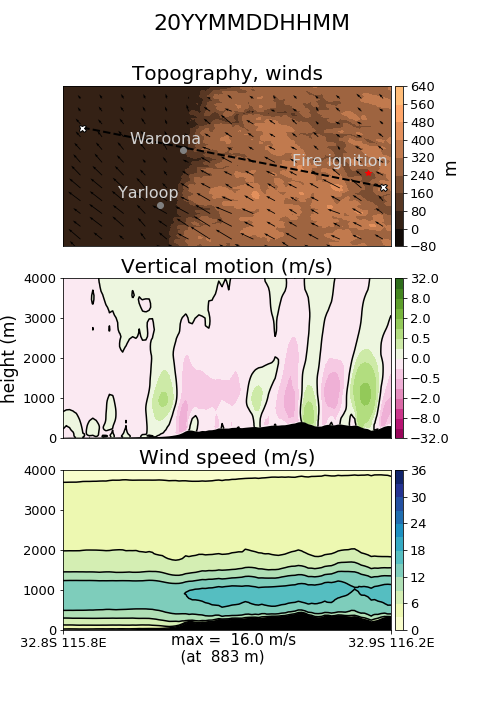

In [8]:
# Lets check the output
## EXAMPLE 

#data = waroona
#extentname='waroona'
#vectorskip=10

#tstep=0
pname="figures/waroona/winds_outline_X1/fig_20YYMMDDHHMM.png"
#pname = winds_2panel(data,tstep, 
#                     extentname=extentname,vectorskip=vectorskip)

Image(filename=pname)


## Now run this in a loop, creating one figure for each time step

The datestamp will be used in each figure name, which lets ffmpeg order the video

### This seems to crash the kernal... not enough RAM? can ipython handle big data?

#### ffmpeg video creation script is in the figures folder

accessfires$cat figures/make_video.sh
#!/bin/bash

#Run this from the subfolder with all your images in it
module load ffmpeg

ffmpeg -pattern_type glob -framerate 2 -i '*.png' -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p video.mp4
accessfires$


In [9]:
# Sirivan loop
extentname='sirivan'
vectorskip=14

if False:
    # Read each file one by one
    for file_si in fio._files_sirivan_:
        data = fio.read_sirivan([file_si])
        # datetime of outputs
        dtime = utils.date_from_gregorian(data['time'])
        
        for tstep in range(2):
            pname = winds_2panel(data,tstep=tstep, 
                                 dtime=dtime[tstep],
                                 extentname=extentname,
                                 vectorskip=vectorskip)
    

In [ ]:
# Waroona loop
extentname='waroona'
vectorskip=9

# List of hours for which we have output.. 0515 - 0614
#date_list = [datetime(2016,1,5,15) + timedelta(hours=x) for x in range(24)]
# first hour is already done, subsequent hours have some missing fields!
date_list = [datetime(2016,1,5,16) + timedelta(hours=x) for x in range(24)]
topography,latt,lont = fio.read_topog('data/waroona/topog.nc')

# Read each hour one by one
for dtime in date_list:
    # Read the files for this hour
    waroona_outputs = fio.read_waroona(dtime,th2=False) # don't need cloud stuff for this plot
    slv, ro1, th1, th2 = waroona_outputs
    
    # grab the outputs desired
    waroona={}
    waroona['wind_speed'] = ro1['wind_speed']
    waroona['x_wind_destaggered'] = ro1['x_wind_destaggered']
    waroona['y_wind_destaggered'] = ro1['y_wind_destaggered']
    waroona['topog'] = topography
    waroona['zth'] = th1['zth']
    waroona['latitude'] = slv['latitude']
    waroona['longitude'] = slv['longitude']
    waroona['upward_air_velocity'] = th1['upward_air_velocity']
    
    
    # datetime of outputs
    timesteps = utils.date_from_gregorian(th1['time'])
    
    # also loop over different transects
    for i_transect in np.arange(1,6.5,1, dtype=int):
        for tstep in range(len(timesteps)):
            pname = winds_2panel(waroona,tstep=tstep,
                                 dtime=timesteps[tstep],
                                 extentname=extentname,
                                 vectorskip=vectorskip, 
                                 transect=i_transect)
    
    # Save ram hopefully
    del waroona, slv, ro1, th1, th2, waroona_outputs

INFO: Reading  data/waroona/umnsaa_2016010516_slv.nc  ... 
INFO: finished reading  data/waroona/umnsaa_2016010516_slv.nc
INFO: Reading  data/waroona/umnsaa_2016010516_mdl_ro1.nc  ... 
INFO: finished reading  data/waroona/umnsaa_2016010516_mdl_ro1.nc
INFO: Reading  data/waroona/umnsaa_2016010516_mdl_th1.nc  ... 
INFO: finished reading  data/waroona/umnsaa_2016010516_mdl_th1.nc
INFO: Saving figure: figures/waroona/winds_outline_X1/fig_201601051609.png
INFO: Saving figure: figures/waroona/winds_outline_X1/fig_201601051619.png
INFO: Saving figure: figures/waroona/winds_outline_X1/fig_201601051630.png
INFO: Saving figure: figures/waroona/winds_outline_X1/fig_201601051640.png
INFO: Saving figure: figures/waroona/winds_outline_X1/fig_201601051650.png
INFO: Saving figure: figures/waroona/winds_outline_X1/fig_201601051700.png
INFO: Saving figure: figures/waroona/winds_outline_X2/fig_201601051609.png
INFO: Saving figure: figures/waroona/winds_outline_X2/fig_201601051619.png
INFO: Saving figure: 

INFO: Saving figure: figures/waroona/winds_outline_X4/fig_201601051900.png
INFO: Saving figure: figures/waroona/winds_outline_X5/fig_201601051810.png
INFO: Saving figure: figures/waroona/winds_outline_X5/fig_201601051820.png
INFO: Saving figure: figures/waroona/winds_outline_X5/fig_201601051830.png
INFO: Saving figure: figures/waroona/winds_outline_X5/fig_201601051840.png
INFO: Saving figure: figures/waroona/winds_outline_X5/fig_201601051849.png
INFO: Saving figure: figures/waroona/winds_outline_X5/fig_201601051900.png
INFO: Saving figure: figures/waroona/winds_outline_X6/fig_201601051810.png
INFO: Saving figure: figures/waroona/winds_outline_X6/fig_201601051820.png
INFO: Saving figure: figures/waroona/winds_outline_X6/fig_201601051830.png
INFO: Saving figure: figures/waroona/winds_outline_X6/fig_201601051840.png
INFO: Saving figure: figures/waroona/winds_outline_X6/fig_201601051849.png
INFO: Saving figure: figures/waroona/winds_outline_X6/fig_201601051900.png
INFO: Reading  data/waroo

INFO: Saving figure: figures/waroona/winds_outline_X2/fig_201601052149.png
INFO: Saving figure: figures/waroona/winds_outline_X2/fig_201601052200.png
INFO: Saving figure: figures/waroona/winds_outline_X3/fig_201601052110.png
INFO: Saving figure: figures/waroona/winds_outline_X3/fig_201601052120.png
INFO: Saving figure: figures/waroona/winds_outline_X3/fig_201601052130.png
INFO: Saving figure: figures/waroona/winds_outline_X3/fig_201601052140.png
INFO: Saving figure: figures/waroona/winds_outline_X3/fig_201601052149.png
INFO: Saving figure: figures/waroona/winds_outline_X3/fig_201601052200.png
INFO: Saving figure: figures/waroona/winds_outline_X4/fig_201601052110.png
INFO: Saving figure: figures/waroona/winds_outline_X4/fig_201601052120.png
INFO: Saving figure: figures/waroona/winds_outline_X4/fig_201601052130.png
INFO: Saving figure: figures/waroona/winds_outline_X4/fig_201601052140.png
INFO: Saving figure: figures/waroona/winds_outline_X4/fig_201601052149.png
INFO: Saving figure: figu

INFO: Reading  data/waroona/umnsaa_2016010600_mdl_ro1.nc  ... 
INFO: finished reading  data/waroona/umnsaa_2016010600_mdl_ro1.nc
INFO: Reading  data/waroona/umnsaa_2016010600_mdl_th1.nc  ... 
INFO: finished reading  data/waroona/umnsaa_2016010600_mdl_th1.nc
INFO: Saving figure: figures/waroona/winds_outline_X1/fig_201601060010.png
INFO: Saving figure: figures/waroona/winds_outline_X1/fig_201601060020.png
INFO: Saving figure: figures/waroona/winds_outline_X1/fig_201601060030.png
INFO: Saving figure: figures/waroona/winds_outline_X1/fig_201601060040.png
INFO: Saving figure: figures/waroona/winds_outline_X1/fig_201601060049.png
INFO: Saving figure: figures/waroona/winds_outline_X1/fig_201601060100.png
INFO: Saving figure: figures/waroona/winds_outline_X2/fig_201601060010.png
INFO: Saving figure: figures/waroona/winds_outline_X2/fig_201601060020.png
INFO: Saving figure: figures/waroona/winds_outline_X2/fig_201601060030.png
INFO: Saving figure: figures/waroona/winds_outline_X2/fig_201601060

## Sample plot showing cloud formation if possible

Vertical motion and relative humidity may be the best proxy?

Showing transect up to 8k altitude or what is best?

##### 211 transect line and wind speed contour

##### 223 Vertical motion transect

##### 224 specific or relative humitidy transect

In [74]:
def clouds_2panel(data, tstep,
                 extentname='waroona',
                 transect=1, 
                 vectorskip=14,
                 quiverscale=60,
                 dtime=None,
                 ext='.png'
                ):
    '''
    211 Plot showing windspeed map and wind speed, along with near sites and transect
    223 vertical motion along transect
    224 water and ice content along transect
    INPUTS:
        topography, vert motion, wind speed, u,v, qc, z,lat,lon, 
        extentname = { 'waroona' | 'sirivan' } choice of two fire locations
        transect = int from 1 to 6 for transect choice
        vectorskip reduces quiver density (may need to fiddle)
        quiverscale changes how long the arrows are (also may need to fiddle)
        dtime is datetime of output 
        ext is the plot extension { '.png' | '.eps' }
    '''
    
    topog=data['topog']
    w=data['upward_air_velocity'][tstep]
    s=data['wind_speed'][tstep]
    u=data['x_wind_destaggered'][tstep]
    v=data['y_wind_destaggered'][tstep]
    z=data['zth'][tstep]
    lat=data['latitude']
    lon=data['longitude']
    qc=data['qc'][tstep]
    
    # datetime timestamp for file,title
    if dtime is None:
        dstamp = "YYYYMMDDHHMM"
        stitle = dstamp
    else:
        dstamp = dtime.strftime("%Y%m%d%H%M")
        stitle = dtime.strftime("%Y %b %d %H:%M (UTC)")
    # figure name and location
    pname="figures/%s/clouds_outline_X%d/fig_%s%s"%(extentname,transect,dstamp,ext)
    
    # set font sizes
    plotting.init_plots()
    
    # get plot extent, and transect
    extent = plotting._extents_[extentname]
    start,end = plotting._transects_["%s%d"%(extentname,transect)]
    
    plt.figure(figsize=[7,10])
    ax1 = plt.subplot(3,1,1)
    
    # top panel is wind speed surface values
    plotting.map_contourf(extent,s[0],lat,lon,
                          cmap=plotting._cmaps_['windspeed'],
                          clabel='m/s')
    plt.title('Horizontal wind speed')
    
    # start to end x=[lon0,lon1], y=[lat0, lat1]
    plt.plot([start[1],end[1]],[start[0],end[0], ], '--k', 
             linewidth=2, marker='o', markersize=5)
    
    # add nearby towns
    if extentname == 'waroona':
        plotting.map_add_locations(['waroona','yarloop'], 
                                   text=['Waroona', 'Yarloop'], 
                                   textcolor='k')
        # add fire ignition
        plotting.map_add_locations(['fire_waroona'],
                                   text = ['Fire ignition'], 
                                   color='r', marker='*', 
                                   textcolor='k')
        # add pyroCB
    else:
        plotting.map_add_locations(['sirivan','uarbry'], 
                                   text=['Sir Ivan','Uarbry'],
                                   dx=[-.02,.05], dy =[-.015,-.03],
                                   textcolor='k')
        # add fire ignition
        plotting.map_add_locations(['fire_sirivan'],
                                   text = ['Fire ignition'], dx=.05,
                                   color='r', marker='*', 
                                   textcolor='k')
        # add pyroCB

    
    # Add vectors for winds
    # just surface, and one every N points to reduce density
    skip = (slice(None,None,vectorskip),slice(None,None,vectorskip))
    #mlon,mlat = np.meshgrid(lon,lat)
    plt.quiver(lon[skip[1]],lat[skip[0]],u[0][skip],v[0][skip], scale=quiverscale)
    
    
    ## Second row is transect plots
    ax2 = plt.subplot(3,1,2)
    plotting.transect_w(w,z, lat, lon,start,end,topog=topog)
    plt.ylabel('height (m)')
    plt.xlabel('')
    
    ax3 = plt.subplot(3,1,3)
    plotting.transect_qc(qc,z,lat,lon,start,end,topog=topog)
    #plt.yticks([])
    plt.xlabel('transect')
    
    # Save figure into animation folder with numeric identifier
    plt.suptitle(stitle)
    print("INFO: Saving figure:",pname)
    plt.savefig(pname)
    plt.close()
    return pname


INFO: Saving figure: figures/waroona/clouds_outline_X1/fig_YYYYMMDDHHMM.png


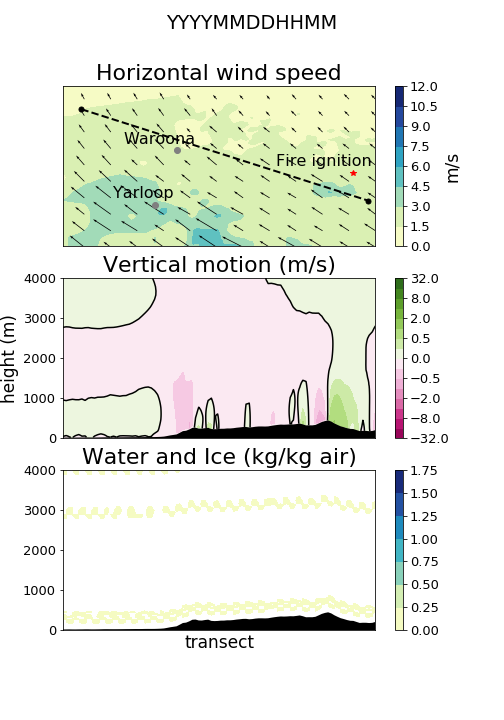

In [75]:
# Lets check the output
## EXAMPLE 

data = waroona
extentname='waroona'
vectorskip=9

tstep=0
pname = clouds_2panel(data, tstep=tstep, 
                     extentname=extentname,vectorskip=vectorskip)
Image(filename=pname)


In [76]:
# Waroona loop
extentname='waroona'
vectorskip=9

# Read each file one by one
for file_si in fio._files_waroona_old_:
    data = fio.read_waroona([file_si])
    # datetime of outputs
    dtime = utils.date_from_gregorian(data['time'])
    
    for tstep in range(2):
        pname = clouds_2panel(data,tstep=tstep, 
                                 dtime=dtime[tstep],
                                 extentname=extentname,
                                 vectorskip=vectorskip)

INFO: Reading  data/waroona/umnsaa_pc2016010515.nc  ... 
INFO: finished reading  data/waroona/umnsaa_pc2016010515.nc
INFO: Saving figure: figures/waroona/clouds_outline_X1/fig_201601051500.png
INFO: Saving figure: figures/waroona/clouds_outline_X1/fig_201601051531.png
INFO: Reading  data/waroona/umnsaa_pc2016010516.nc  ... 
INFO: finished reading  data/waroona/umnsaa_pc2016010516.nc
INFO: Saving figure: figures/waroona/clouds_outline_X1/fig_201601051601.png
INFO: Saving figure: figures/waroona/clouds_outline_X1/fig_201601051630.png
INFO: Reading  data/waroona/umnsaa_pc2016010517.nc  ... 
INFO: finished reading  data/waroona/umnsaa_pc2016010517.nc
INFO: Saving figure: figures/waroona/clouds_outline_X1/fig_201601051701.png
INFO: Saving figure: figures/waroona/clouds_outline_X1/fig_201601051731.png
INFO: Reading  data/waroona/umnsaa_pc2016010518.nc  ... 
INFO: finished reading  data/waroona/umnsaa_pc2016010518.nc
INFO: Saving figure: figures/waroona/clouds_outline_X1/fig_201601051800.png


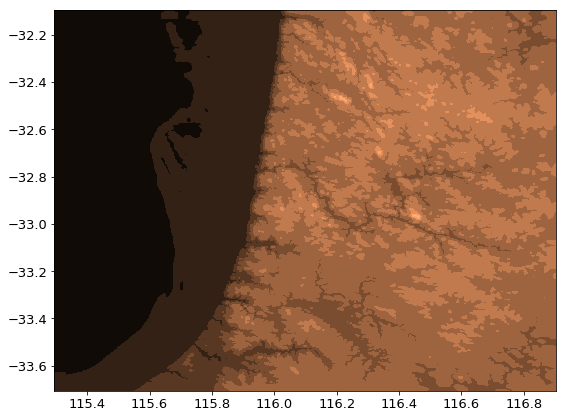

In [6]:
topography,latt,lont = fio.read_topog('data/waroona/topog.nc')
plt.contourf(lont,latt,topography,cmap='copper')

In [9]:
for i_transect in np.arange(1,6.5,1, dtype=int):
    print(i_transect)

1
2
3
4
5
6
